In [5]:
"""
Collect Data: Capture and label images of our handwriting.
    [ ] Chelsey
    [ ] Shawn
    [X] Starter data set (MNIST)
    [X] Starter data set (EMNIST ByClass)

Preprocess Data: Resize, normalize, and encode the images and labels.

Build a CNN Model: Use Keras to define a CNN suitable for image classification.
Train the Model: Fit the model on your handwriting dataset.
Evaluate and Predict: Assess model accuracy and use it to predict new handwriting samples.
"""

import cv2
import numpy as np
import os
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
import pickle
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import keras_tuner as kt


In [6]:
# Load the EMNIST Letters dataset
(train_ds, test_ds), ds_info = tfds.load(
    'emnist/byclass',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

# Function to visualize some samples
def plot_samples(dataset, num_samples=9):
    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(dataset.take(num_samples)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(image.numpy().squeeze(), cmap="gray")
        plt.title(f"Label: {label.numpy()}")
        plt.axis('off')
    plt.show()

# Plot some samples from the training dataset
plot_samples(train_ds)

# Preprocessing function to normalize the images
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image, label

def augment(image, label):
    # Apply random transformations to the image
    image = tf.image.random_brightness(image, max_delta=0.1)  # Random brightness adjustment
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  # Random contrast adjustment
    image = tf.image.resize_with_crop_or_pad(image, 30, 30)  # Add padding for more room to rotate
    image = tf.image.random_crop(image, size=[28, 28, 1])  # Crop back to 28x28
    
    return image, label

# Prepare datasets with preprocessing and augmentation
train_ds = train_ds.map(preprocess).map(augment).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

# Define the model-building function for Keras Tuner
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(
        filters=hp.Int('filters', min_value=32, max_value=128, step=32),
        kernel_size=(3, 3),
        activation='relu',
        input_shape=(28, 28, 1)))
    model.add(tf.keras.layers.MaxPooling2D(2, 2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(
        units=hp.Int('units', min_value=128, max_value=512, step=128),
        activation='relu'))
    model.add(tf.keras.layers.Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(tf.keras.layers.Dense(62, activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-3, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])

    return model

# Create a tuner
tuner = kt.Hyperband(build_model, objective='val_accuracy', max_epochs=10, factor=3, directory='Resources', project_name='emnist_tuning')

stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

tuner.search(train_ds, epochs=20, validation_data=test_ds, callbacks=[stop_early])

# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best number of filters in Conv2D: {best_hp.get('filters')}")
print(f"Best number of units in Dense layer: {best_hp.get('units')}")
print(f"Best dropout rate: {best_hp.get('dropout')}")
print(f"Best learning rate: {best_hp.get('learning_rate')}")

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.fit(train_ds, epochs=10, validation_data=test_ds)

# Evaluate the model
test_loss, test_accuracy = best_model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.2f}")

Trial 17 Complete [01h 02m 45s]
val_accuracy: 0.8625895380973816

Best val_accuracy So Far: 0.8625895380973816
Total elapsed time: 1d 01h 29m 57s

Search: Running Trial #18

Value             |Best Value So Far |Hyperparameter
96                |32                |filters
512               |512               |units
0.4               |0.3               |dropout
0.0001            |0.001             |learning_rate
10                |10                |tuner/epochs
4                 |4                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
2                 |2                 |tuner/round
0014              |0012              |tuner/trial_id

Epoch 5/10
 9478/21811 ━━━━━━━━━━━━━━━━━━━━ 15:35 76ms/step - accuracy: 0.8442 - loss: 0.4486

KeyboardInterrupt: 

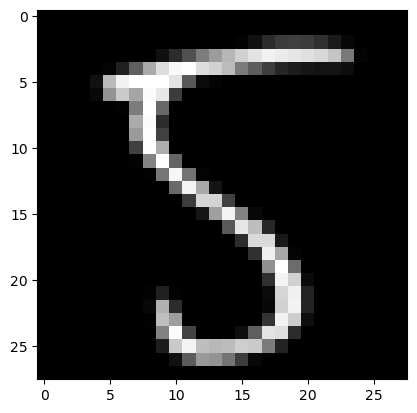

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Character: N
Prediction confidence: 0.69


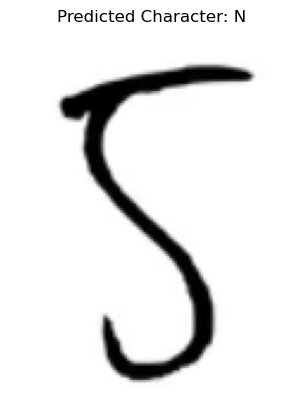

In [13]:
# source image
image_path = "Resources/Test Images/test5b.png"

# Define the class mapping for EMNIST ByClass
emnist_byclass_labels = [
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',   # Digits 0-9
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',  # Uppercase A-Z
    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'   # Lowercase a-z
]

# Define the image preprocessing function (similar to how it was done for the dataset)
def preprocess_image(image_path):
    # Load the image using PIL
    img = Image.open(image_path).convert('L')  # Convert to grayscale if needed
    img = ImageOps.invert(img) # Invert the image colors if the background is white and digits are black 
    img = img.resize((28, 28))  # Resize to 28x28 pixels (same as EMNIST)
    
    plt.imshow(img, cmap='gray') 
    plt.show()

    # Convert the image to a NumPy array and normalize it
    img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
    img_array = img_array.reshape(1, 28, 28, 1)  # Reshape to (1, 28, 28, 1) for batch dimension
    
    return img_array

# Function to make a prediction on a single image
def predict_image(model, image_path):
    processed_image = preprocess_image(image_path)
    
    # Get model prediction (output probabilities for each class)
    predictions = model.predict(processed_image)
    
    # Find the class with the highest probability
    predicted_class = np.argmax(predictions, axis=1)[0]
    
    return predicted_class, predictions

# Function to decode predicted class index to character
def decode_prediction(predicted_class):
    return emnist_byclass_labels[predicted_class]

# usage:
predicted_class, predictions = predict_image(best_model, image_path)
predicted_character = decode_prediction(predicted_class)

print(f"Predicted Character: {predicted_character}")
print(f"Prediction confidence: {predictions[0][predicted_class]:.2f}")

# Visualize the image for confirmation
plt.imshow(np.array(Image.open(image_path)), cmap='gray')
plt.title(f"Predicted Character: {predicted_character}")
plt.axis('off')
plt.show()